In [8]:
import pandas as pd
import os
import matplotlib.patches as mpatches
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
import random

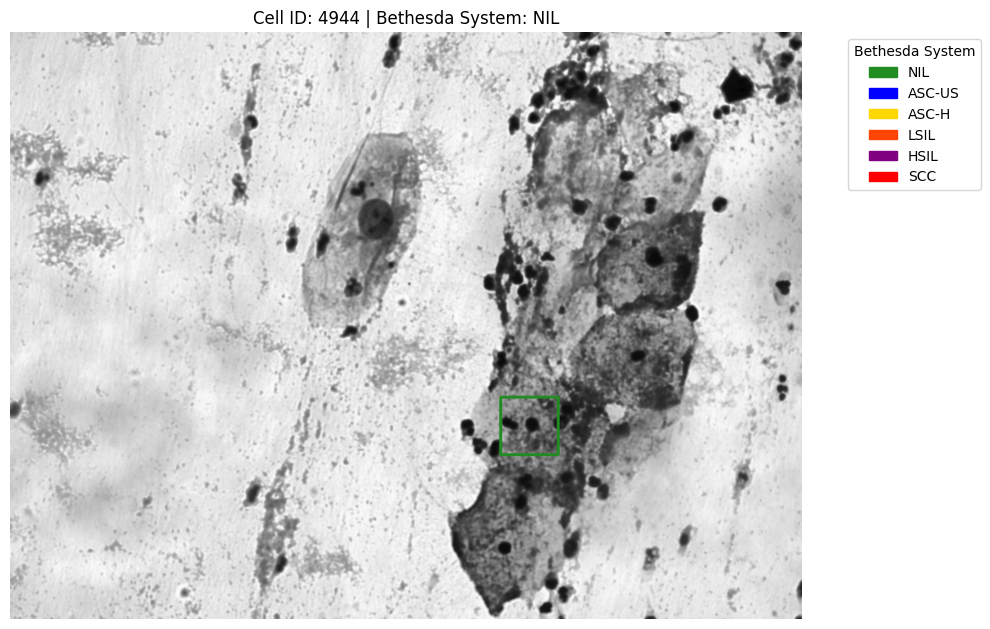

In [10]:

# Load Data
df = pd.read_csv(r"D:\Cerviical_Sem8\Info\classifications.csv", index_col='cell_id')
df["bethesda_system"] = df["bethesda_system"].replace("Negative for intraepithelial lesion", "NIL")

# Define image directory and select an image
main_img_dir = r'D:\Cerviical_Sem8\SSL_Cervical_OriginalImages'
num = random.randint(df.index.min(), df.index.max())
# num = int(input("Enter a number: "))  # Cell ID
get_img_filename = df.loc[num, 'image_filename']
img_path = os.path.join(main_img_dir, get_img_filename)

# Load the image in grayscale
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


if original_img is None:
    raise FileNotFoundError(f"Image at {img_path} could not be loaded. Please check the file path.")

# Bethesda Colors (BGR format for OpenCV)
bethesda_colors = {
    'NIL': (34, 139, 34),   # Forest Green
    'ASC-US': (255, 0, 0),   # Pure Blue
    'ASC-H': (0, 215, 255),  # Bright Yellow
    'LSIL': (0, 69, 255),    # Deep Orange
    'HSIL': (128, 0, 128),   # Purple
    'SCC': (0, 0, 255)       # Pure Red
}

# 🔹 Step 1: Noise Reduction
sigma = 1.5
denoised_image = gaussian(original_img, sigma=sigma)

# 🔹 Step 2: Contrast Enhancement (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
contrast_enhanced_image = clahe.apply((denoised_image * 255).astype(np.uint8))

# 🔹 Step 3: Convert to BGR (Necessary for Color Annotations)
color_image = cv2.cvtColor(contrast_enhanced_image, cv2.COLOR_GRAY2BGR)

# Get Nucleus Coordinates & Bethesda Label
x, y = int(df.loc[num, 'nucleus_x']), int(df.loc[num, 'nucleus_y'])
label = df.loc[num, 'bethesda_system']
color = bethesda_colors.get(label, (255, 255, 255))  # Default to white if label is missing
# Draw Rectangle Around Nucleus (Colored Bounding Box)
cv2.rectangle(color_image, (x - 50, y - 50), (x + 50, y + 50), color, 3)

# 🔹 Step 4: Display the Image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis('off')

# Add Legend
legend_patches = [mpatches.Patch(color=[c[2] / 255, c[1] / 255, c[0] / 255], label=l) for l, c in bethesda_colors.items()]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title='Bethesda System')
plt.title(f'Cell ID: {num} | Bethesda System: {label}')
plt.axis('off')
plt.tight_layout()
plt.show()